# General Note

Hello,
What can be seen below is my attempt to tackle the Leaf classification problem. I used the workflow of first putting up
a simple model that works and then start to fine tune and tackle its caveats.
Due to time constraints and in order to focus i couldn't always do it the 'Pythonic', clean or scalable way.
ofcourse there is a lot to go further and improve - e.g extracting my own features from the images themselves or to fine tune more the classifiers parameters, or trying additional classifiers.

I hope the below notebook is sufficient and demonstrate my ability to catch up the relevant skills you are looking for.
Please let me know if any additional requirement is needed.

Idan

# Environment setup

In [201]:
# Importing required general packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [202]:
%matplotlib inline

# Getting and setting the data

In [203]:
## Importing the training set into a DataFrame
train = pd.read_csv('train.csv',index_col=0)

In [204]:
y = train.species 
X = train.iloc[:,1:(64*3+1)]

print(X.columns)             ## Checking we got the correct columns

Index(['margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6',
       'margin7', 'margin8', 'margin9', 'margin10',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=192)


# Data validation

In [205]:
## Missing values check
mis_val = np.sum(train.isnull().values)
if  mis_val == 0:
    print("Yey, No missing values")
else:
    print("Found "+str(mis_val)+" missing values")

Yey, No missing values


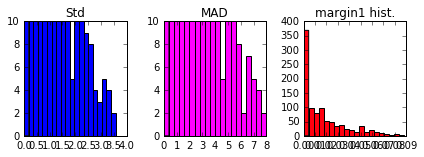

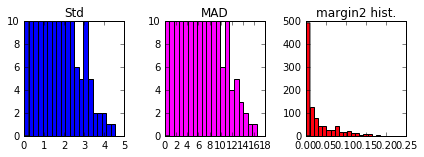

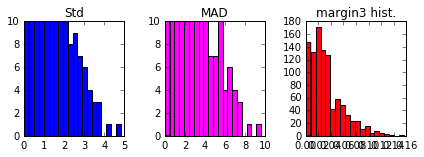

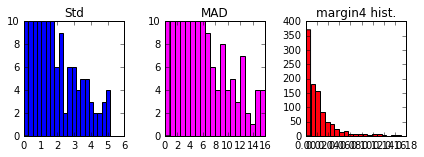

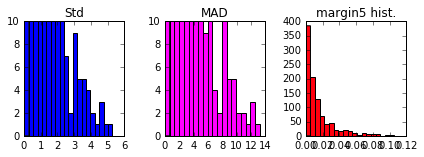

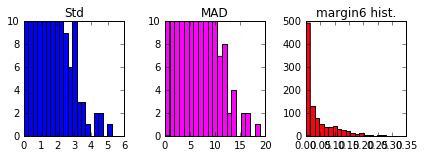

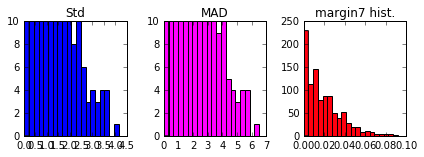

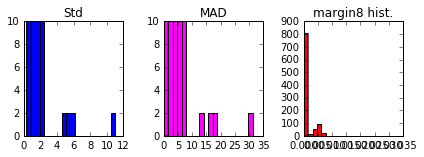

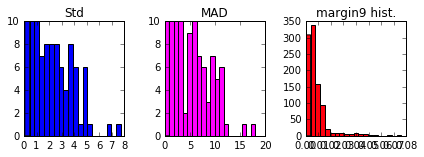

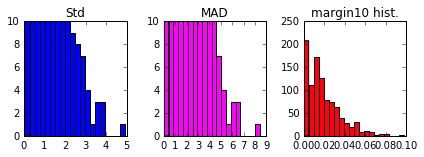

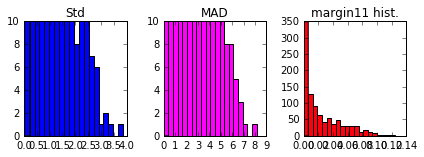

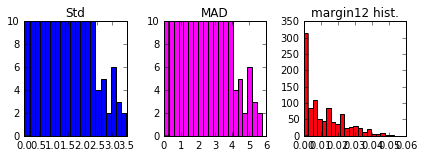

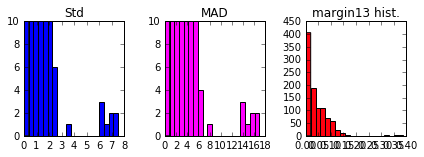

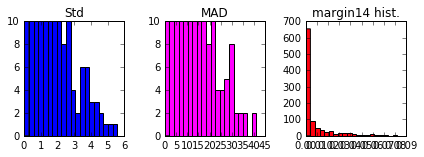

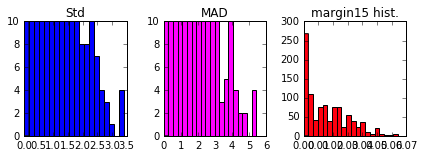

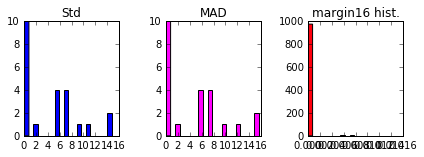

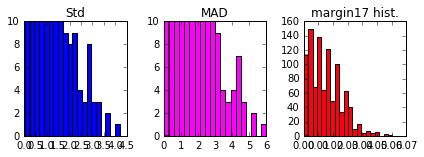

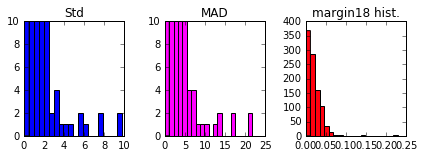

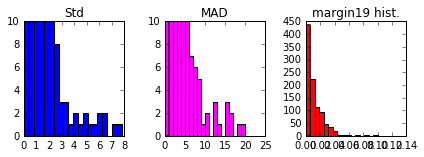

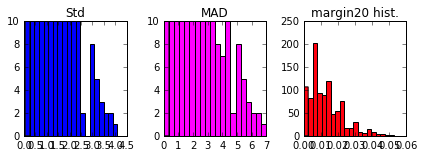

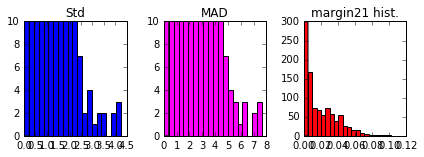

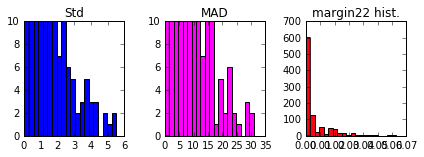

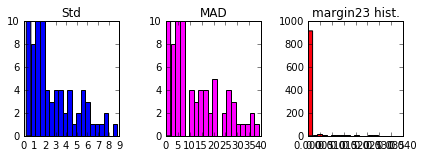

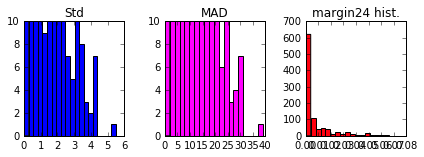

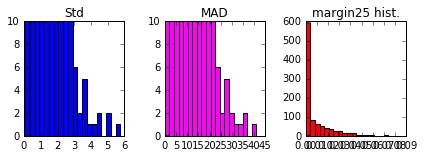

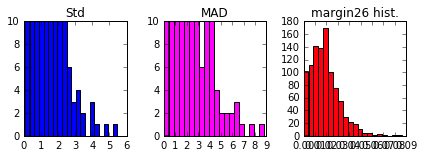

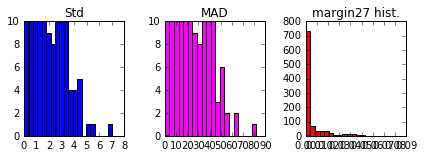

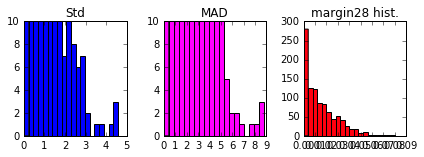

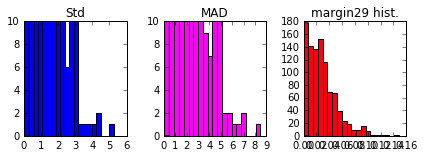

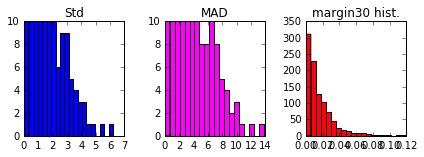

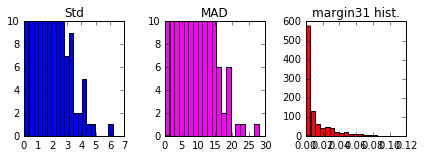

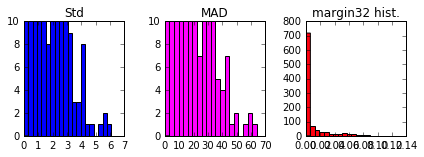

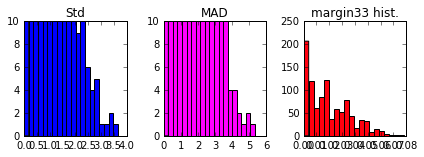

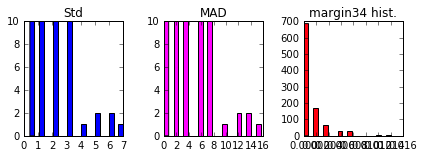

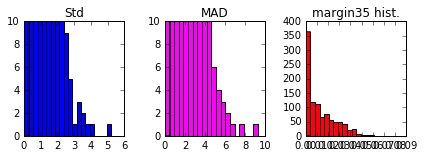

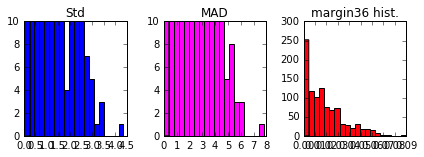

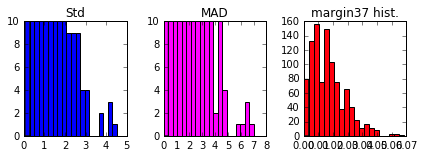

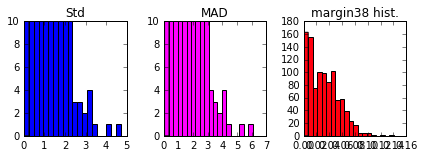

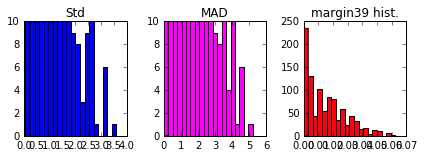

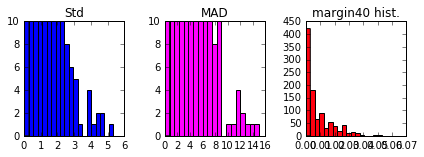

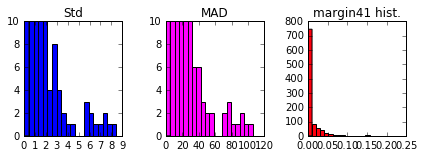

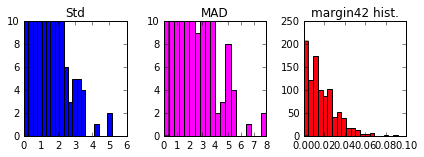

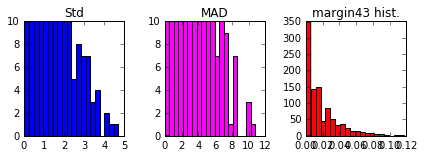

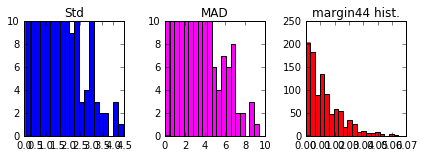

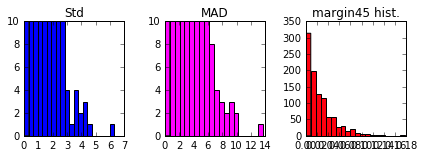

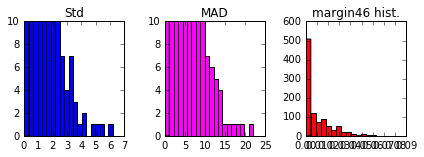

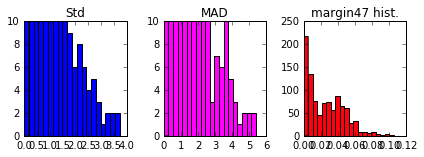

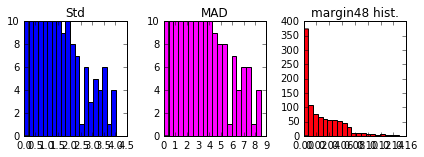

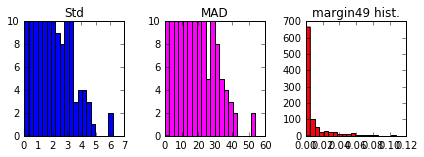

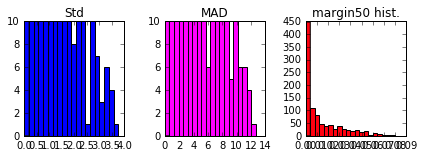

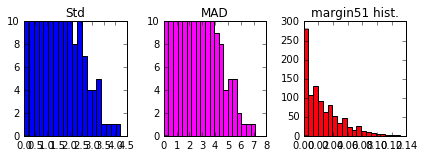

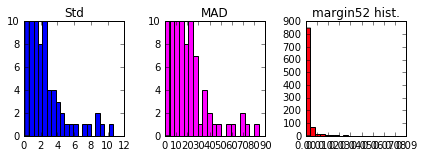

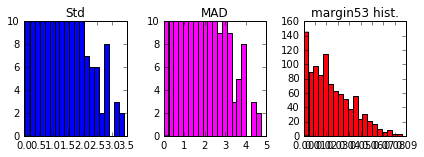

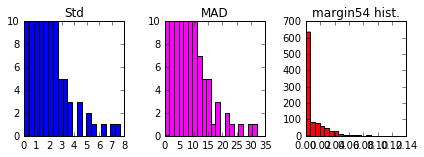

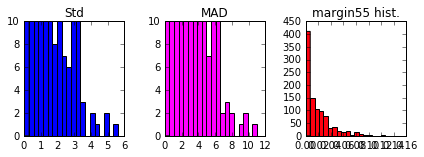

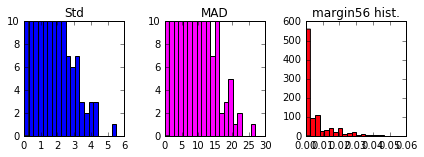

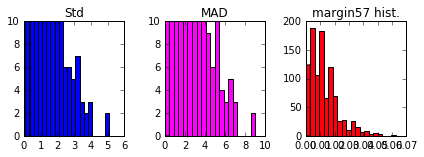

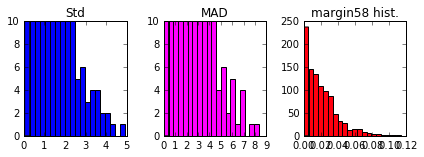

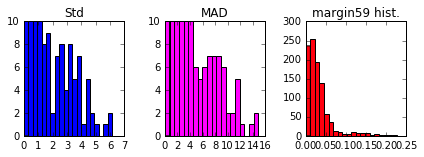

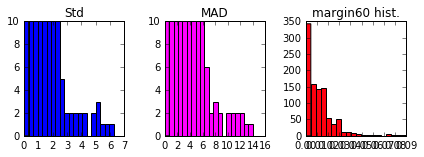

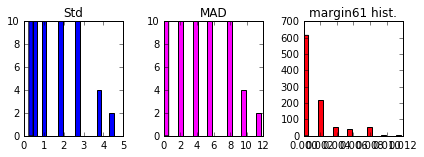

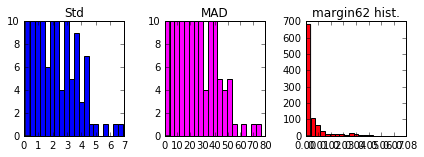

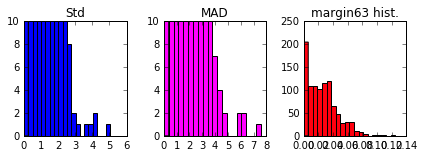

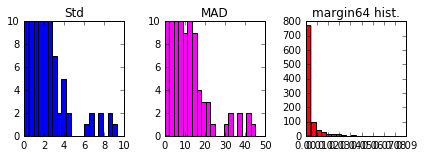

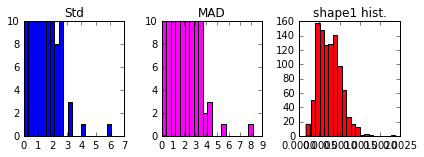

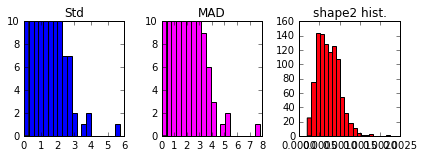

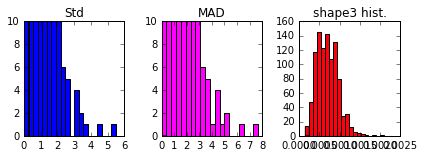

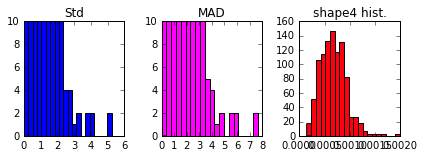

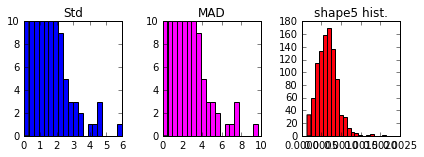

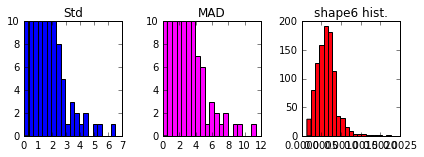

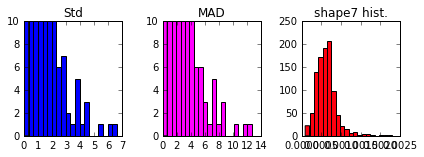

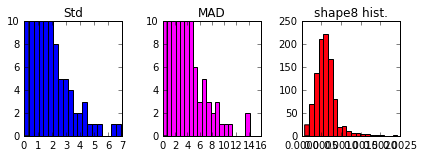

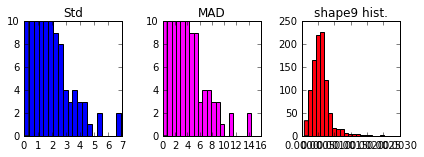

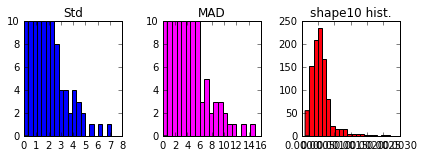

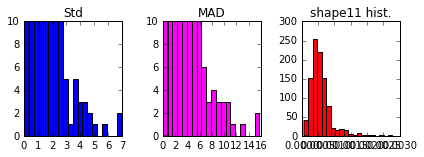

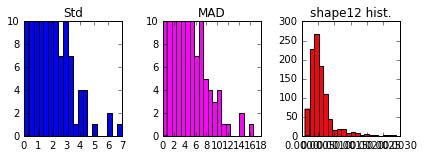

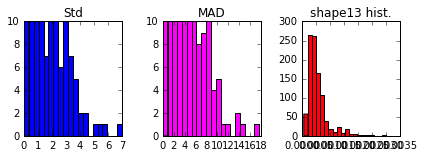

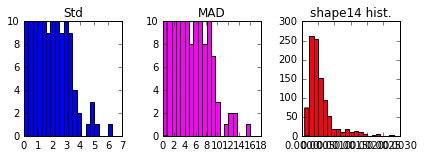

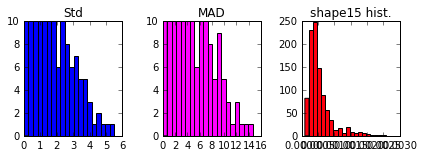

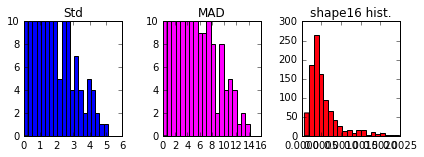

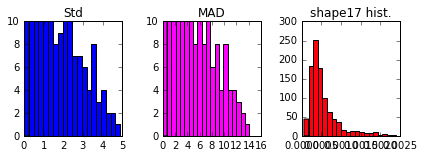

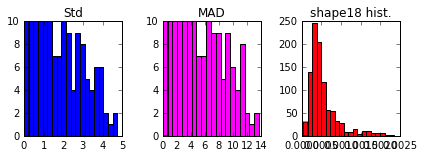

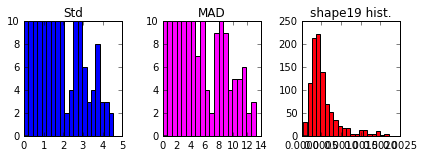

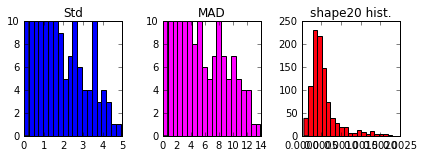

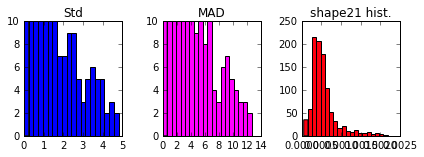

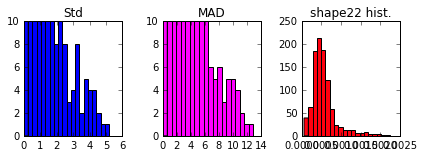

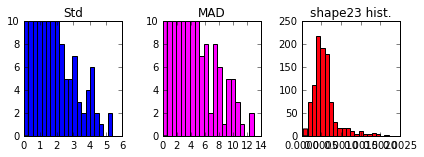

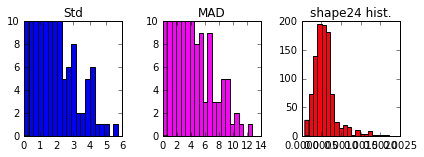

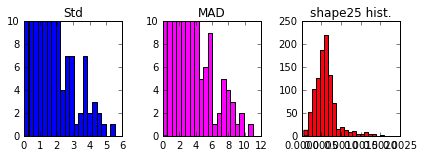

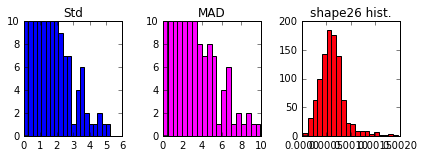

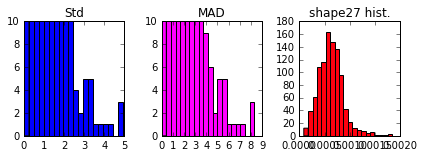

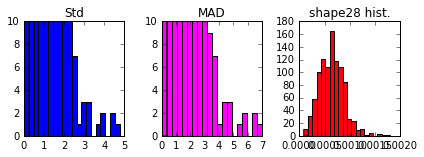

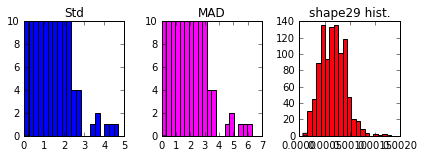

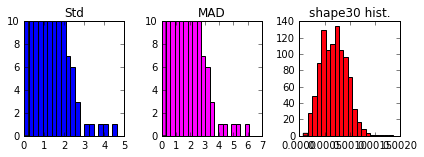

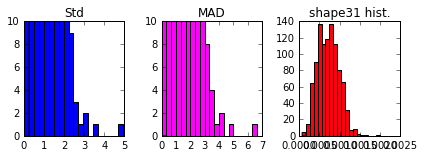

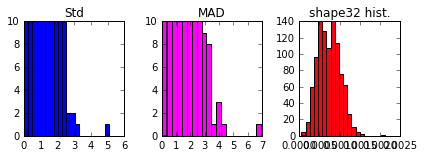

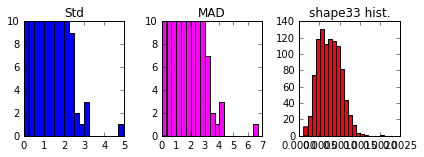

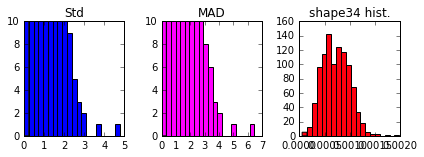

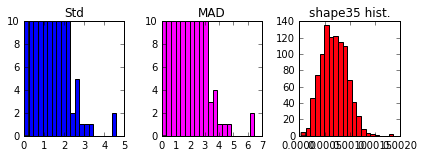

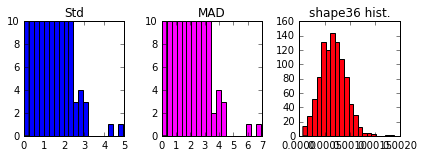

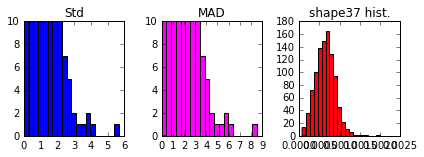

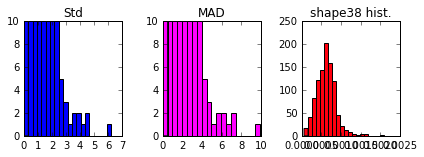

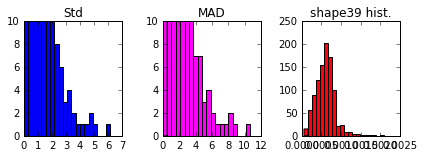

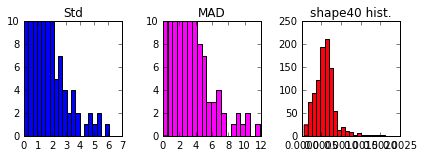

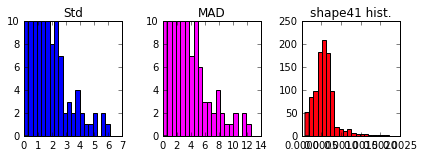

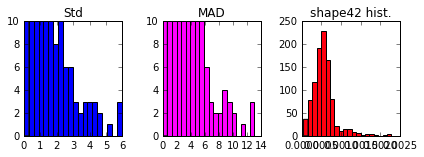

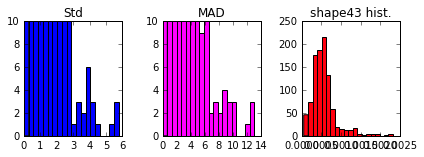

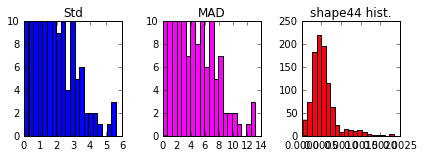

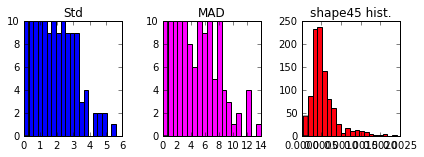

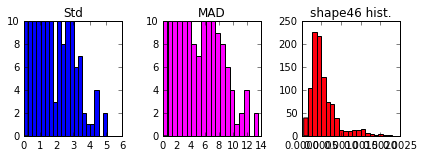

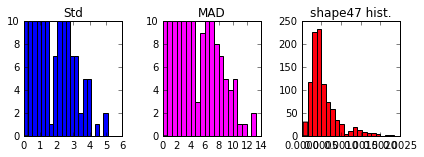

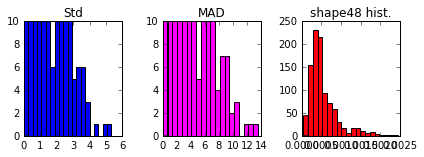

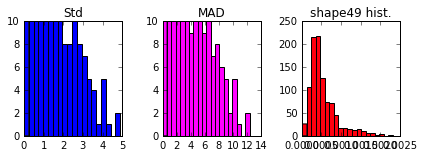

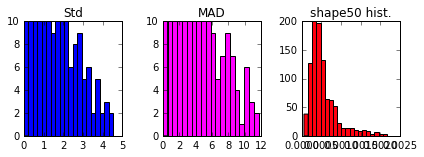

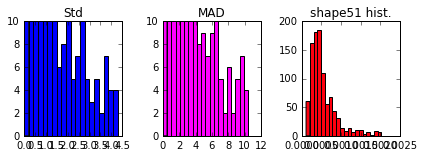

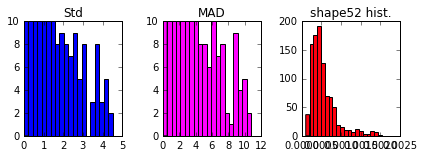

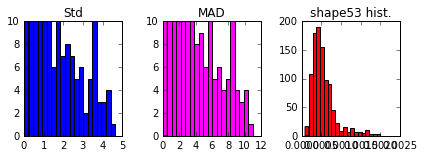

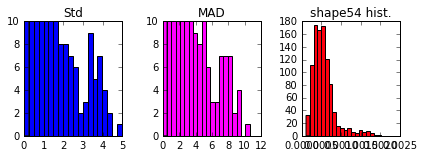

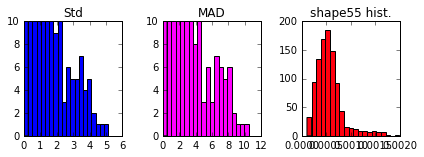

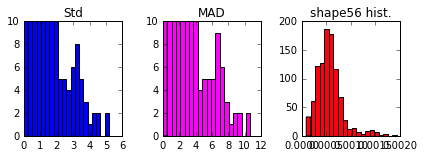

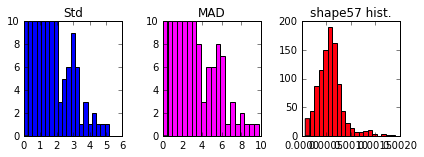

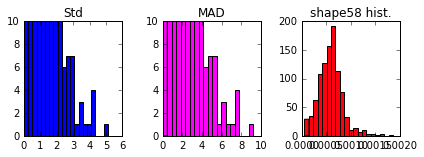

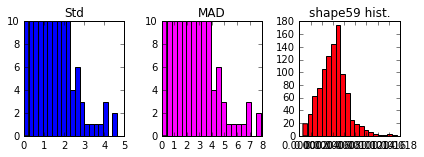

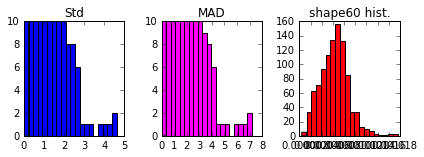

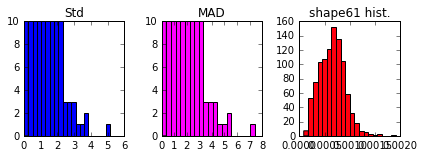

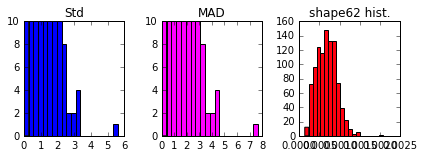

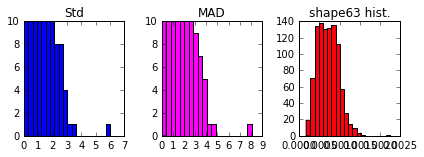

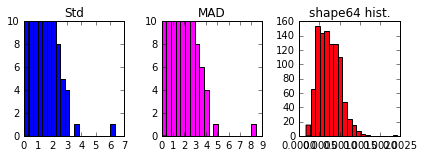

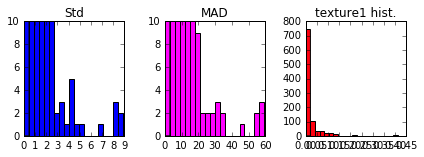

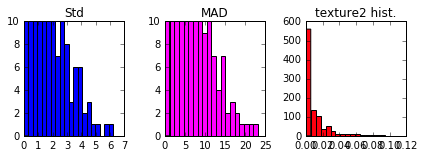

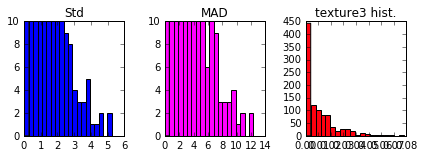

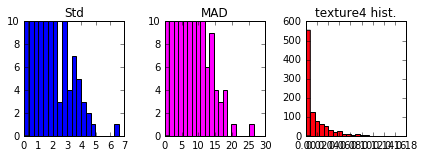

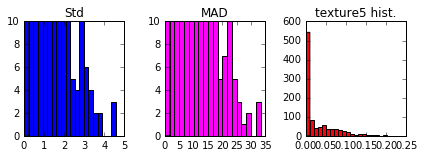

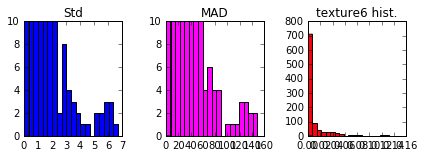

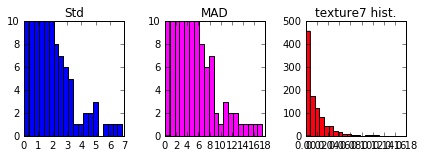

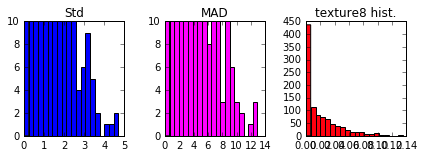

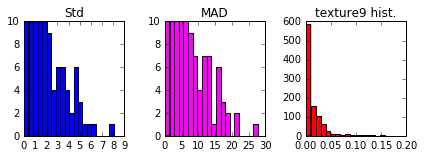

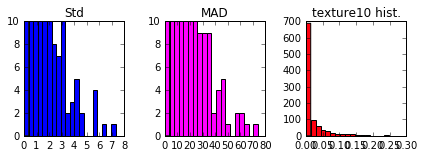

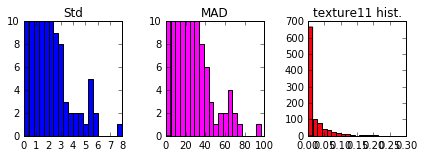

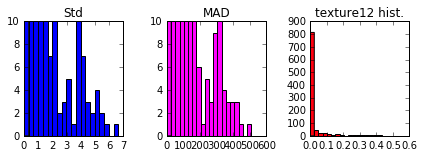

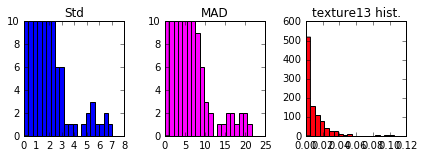

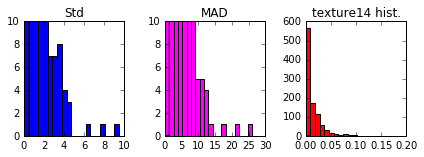

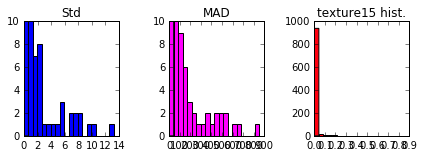

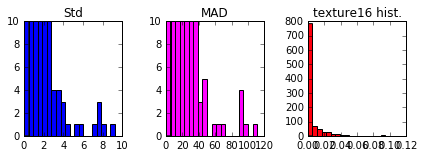

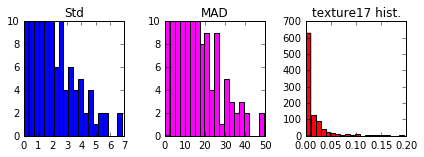

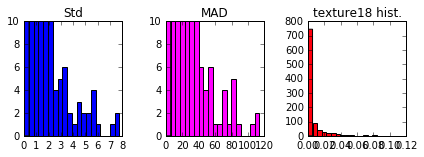

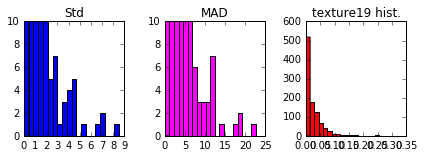

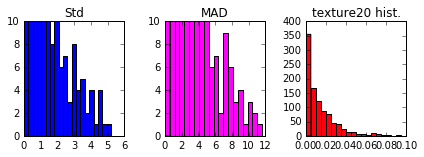

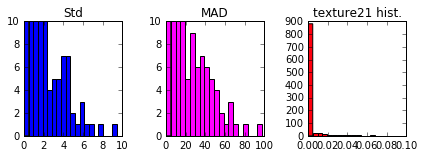

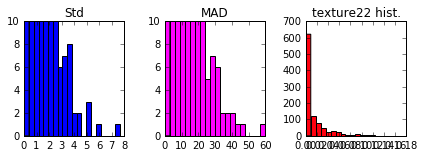

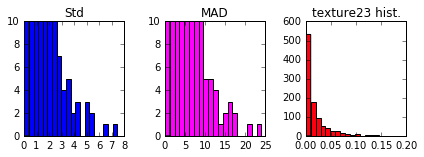

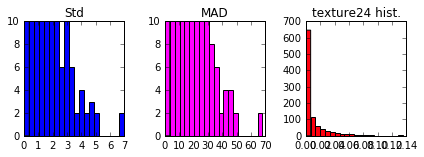

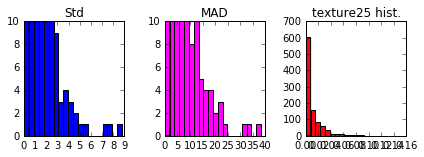

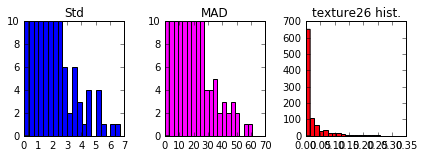

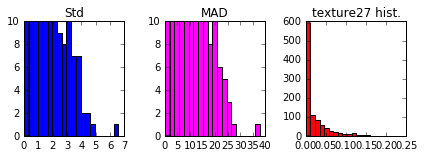

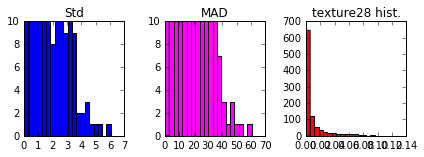

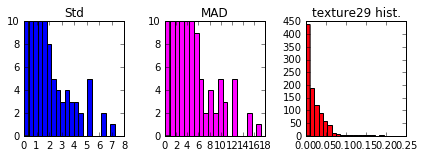

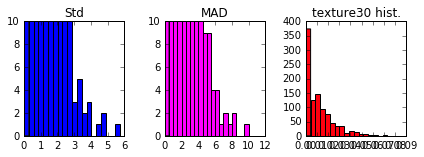

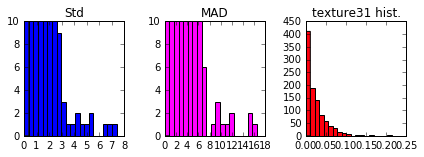

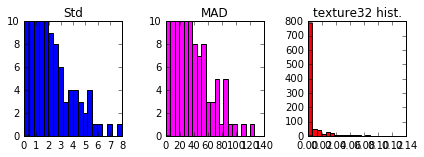

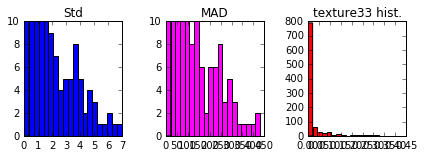

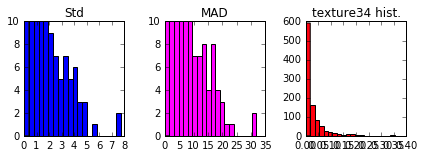

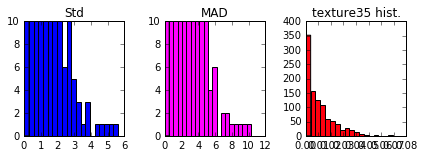

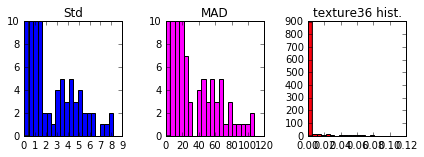

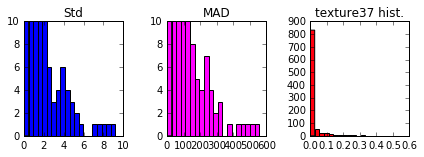

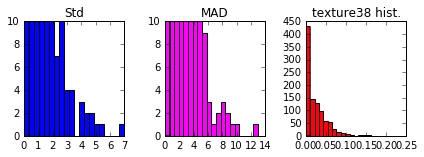

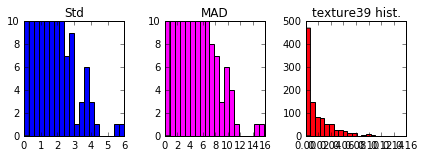

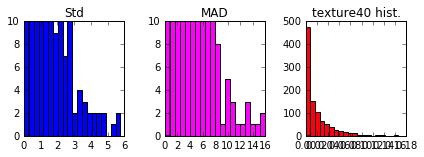

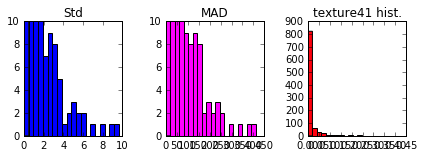

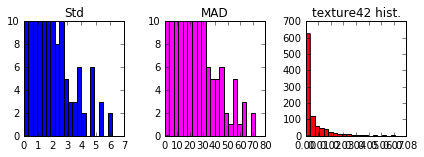

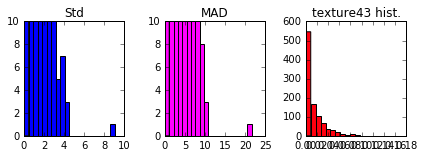

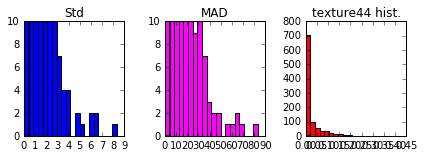

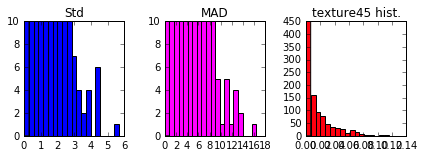

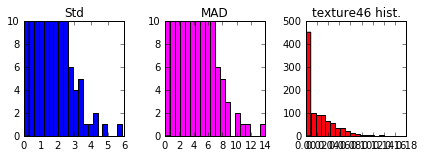

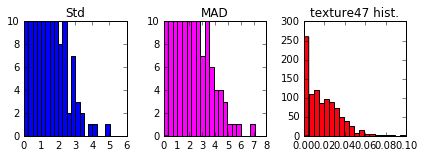

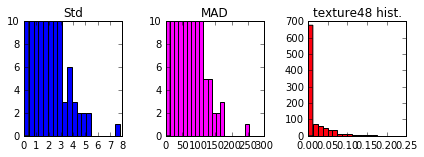

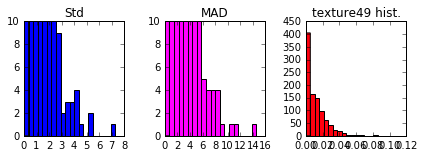

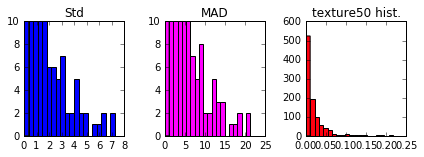

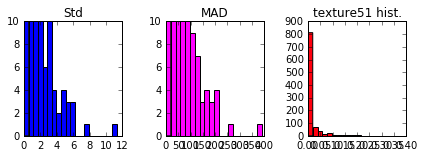

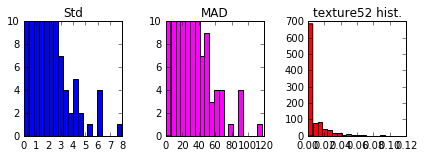

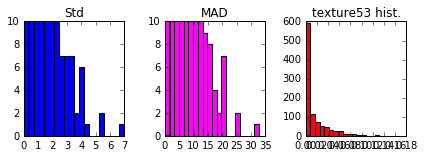

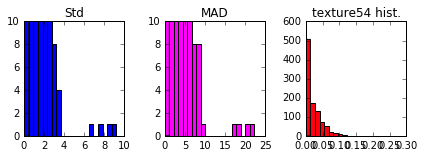

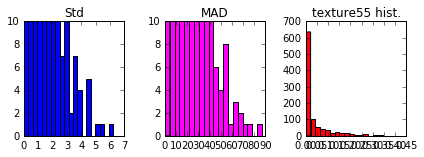

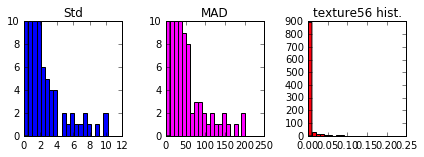

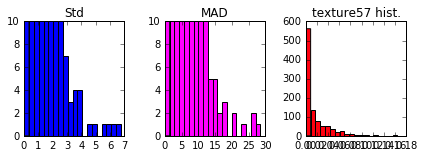

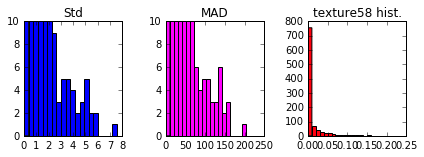

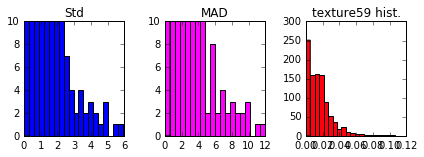

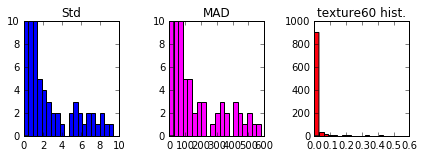

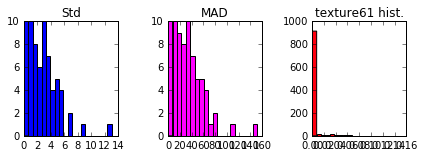

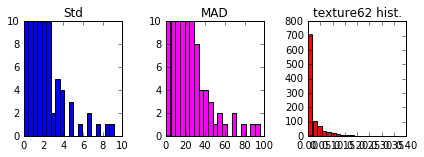

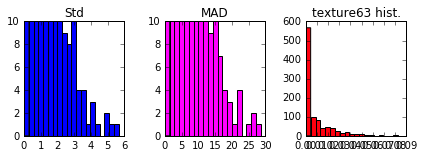

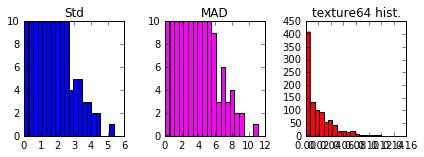

In [206]:
## Outliers check

## Visualizing 3 sets of data for each feature:
##    1) Histogram of samples distance from the *mean*, in standard deviation terms.
##    2) Histogram of samples distance from the *median*, using Median Absolute Deviation approach
##       this method emphsize the distance from the median, thus making outliers to be more easily spotted.
##    3) General histogram of the feature values, to get a sense of the underlying data.

for i in range(X.shape[1]):    
    feature_i = X.values[:,i]
    
    ## Calculating std distance from mean
    f_mean = feature_i.mean()
    f_median = np.median(feature_i)
    f_std = feature_i.std()
    f_dev = abs(feature_i - f_mean) / f_std

    ## Calculating MAD distance from median
    med_dev = abs(feature_i - f_median)
    MAD = np.median(med_dev)
    if MAD == 0: MAD = 0.001                    ## to prevent raising errors, 
    f_med_dev = med_dev / MAD

    ## Plotting it all for a visual review.
    plt.subplot(231)
    plt.hist(f_dev,bins=20)
    plt.title("Std")
    plt.ylim(ymax=10)                           ## without this y-axis limit, a 1 observation outlier will be "lost" in scale
    plt.subplot(232)
    plt.hist(f_med_dev,bins=20,color='#ff00ff')
    plt.title("MAD")
    plt.ylim(ymax=10)                           ## without this y-axis limit, a 1 observation outlier will be "lost" in scale
    plt.subplot(233)
    plt.hist(feature_i,bins=20,color='#ff000f')
    plt.title(str(X.columns[i])+" hist.")
    plt.tight_layout()
    plt.show()
    
    ## Due to the high number of features, a good solution will be a computaional evaluation of outliers, 
    ## following a certain rule (f_med_dev > some number). As this requires better understanding of the features
    ## and figuring out what is the best 'some number', due to time constraints i haven't implemented it here. 

# Splitting to train-test sets

In [207]:
## Spliting into train-test sets while maintaining the classes dispersion in those sets
from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(y,1, test_size=.3, random_state=42)

for train_i, test_i in sss:
    X_train, X_test = X.values[train_i], X.values[test_i]
    y_train, y_test = y[y.index[train_i]], y[y.index[test_i]]

# Training the model - logistic regression

In [208]:
from sklearn.linear_model import LogisticRegression

## Defining logistic regression classifier to be used in a One vs the Rest method.
## Currently with all defualt settings, just to have a working model to start with.

classifier = LogisticRegression()
classifier.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Evaluating the logit model

Metrics 
Log loss = 4.240
f1 test = 56.23%


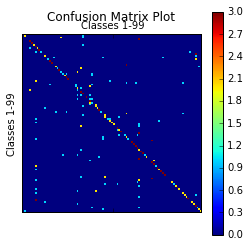

' the confusion matrix above show us that some classes (those vertical dotted lines) are "stealing" correct classifications. we can deal with this by choosing another classifier, or by inspecting those "aggressive" classes and why are they "stealing" other classes classifications.'

In [209]:
## Evaluating model by 2 metrics - Log loss, which is also the competition metric for the scoreboard
##                                 f1 test - a weighted percision-recall metric, in order to take them both into account.

from sklearn.metrics import log_loss, f1_score
print("Metrics \n=======")

logloss = log_loss(y_test,classifier.predict_proba(X_test))
print("Log loss = {:.3f}".format(logloss))

test_prediction = classifier.predict(X_test)
f1 = f1_score(y_test,test_prediction, average='micro')
print('f1 test = {:.2%}'.format(f1))

## Also looking at the confusion matrix to get a glimpse at the performance of our model. a perfect diagonal line will
## mean the model has no mis-classifications at all. 
from sklearn.metrics import confusion_matrix
confusion_mat_df = pd.DataFrame(confusion_matrix(y_test,test_prediction),classifier.classes_,classifier.classes_)
plt.matshow(confusion_mat_df)
plt.colorbar()
plt.title('Confusion Matrix Plot')
plt.xticks([50],['Classes 1-'+str(len(confusion_mat_df.columns))])
plt.yticks([])
plt.ylabel('Classes 1-'+str(len(confusion_mat_df.columns)))
plt.show()

''' the confusion matrix above show us that some classes (those vertical dotted lines) are "stealing" correct classifications. we can deal with this by choosing another classifier, or by inspecting those "aggressive" classes and why are they "stealing" other classes classifications.'''

# Improving the model

In [210]:
## As seen, the simple, unadjusted logistic regression model doesn't perform very well with current data -
## f1 test results are quite low (56%), and log loss is also high (atleast compare to the scoreboard)

## next i'll try several improvement paths.

# Feature engineering

In [211]:
print("Number of features: "+str(len(X.columns)))
print("Number of samples: "+str(len(y)))
print("Number of training samples: "+str(len(y_train)))

''' It seems that the samples-features ratio is quite low, thus model fitting may under-perform. I will analyze the features to look for redundant features we can drop/merge  '''

Number of features: 192
Number of samples: 990
Number of training samples: 693


' It seems that the samples-features ratio is quite low, thus model fitting may under-perform. I will analyze the features to look for redundant features we can drop/merge  '

In [212]:
## Next i'll check for correlations between the model features. strong correlations will allow us to remove some of the correlated features.
corr_matrix = X.corr()
corr_thres = 0.8
adj_corr_matrix = corr_matrix * (abs(corr_matrix) > corr_thres) * (corr_matrix != 1)

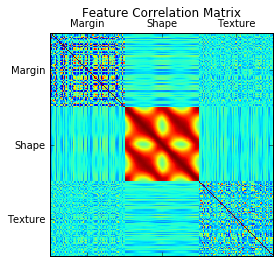

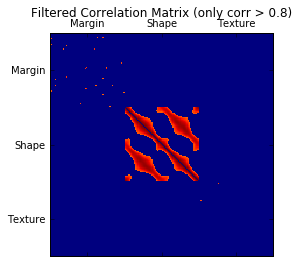

In [213]:
## Visual correlation outout
plt.matshow(corr_matrix)
plt.xticks([32,32+64,32+64*2],["Margin","Shape","Texture"])
plt.yticks([32,32+64,32+64*2],["Margin","Shape","Texture"])
plt.title("Feature Correlation Matrix")
plt.matshow(adj_corr_matrix)
plt.xticks([32,32+64,32+64*2],["Margin","Shape","Texture"])
plt.yticks([32,32+64,32+64*2],["Margin","Shape","Texture"])
plt.title("Filtered Correlation Matrix (only corr > " + str(corr_thres) +")")
plt.show()

In [214]:
## The matrix plots above clearly show that the shape1 to shape64 features are correlated with each other (not all with all, but some with some)

In [ ]:
## Can also be looked at a numerical output
j = 0
for index, row in adj_corr_matrix.iterrows():    
    for i in range(j,len(row)):
        if abs(row[i]) > corr_thres: 
            print(index + " and " + row.keys()[i] + " are correlated = " + "{:.3f}".format(row[i]))
    j += 1

In [216]:
## After identifying a bunch of strong correlated features ('shape1'...'shape64'), and not wanting to lose the data they may hold, i'll use the Principal Component Analysis method to reduce the dimensionality of those 64 features

In [217]:
## Preparing to drop/replace the correlated 'shape' features
drop_list = []
for i in list(range(1,65)): drop_list.append("shape"+str(i))
    
print("check: drop_list = ["+str(drop_list[0])+" ... "+str(drop_list[-1]+"]\n"))

check: drop_list = [shape1 ... shape64]



In [218]:
## PCAing the 'shape' correlated features
from sklearn.decomposition import PCA

X_shape = X[drop_list].copy()         ## extract the correlated features from the dataset 
pca = PCA(n_components=0.95)          ## defining the PCA method to reduce dimensions (better say 'add') until atleast 95% variance explained constraint is satisfied (rule of thumb)
X_shape_pca = pca.fit_transform(X_shape)

print("Features '" + drop_list[0]+"' to '"+drop_list[-1]+"', "+str(len(drop_list))+" features \n"+
      "were reduced by PCA method to "+str(pca.n_components_)+" dimensions \n"+
      "with explained variance of {:.2%}".format(sum(pca.explained_variance_ratio_)))

X_shape_pca_labels = []
for i in range(pca.n_components_):
    X_shape_pca_labels.append("shape_pca" + str(i+1))
    
X_shape_pca = pd.DataFrame(X_shape_pca,X.axes[0],X_shape_pca_labels)    

Features 'shape1' to 'shape64', 64 features 
were reduced by PCA method to 3 dimensions 
with explained variance of 96.38%


In [219]:
## Replacing the new shape_pca features with the old correlated shape1 to shape64 features
X = X.drop(drop_list,axis=1)
X = pd.concat([X,X_shape_pca],axis=1)

print(X.columns)             ## Checking we got the correct columns

Index(['margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6',
       'margin7', 'margin8', 'margin9', 'margin10',
       ...
       'texture58', 'texture59', 'texture60', 'texture61', 'texture62',
       'texture63', 'texture64', 'shape_pca1', 'shape_pca2', 'shape_pca3'],
      dtype='object', length=131)


# Re-running the logistic regression model (after PCA)

In [220]:
## re-Spliting into train-test sets using previous made stratifiedshuffle parameter and the new X (After PCA)
for train_i, test_i in sss:
    X_train, X_test = X.values[train_i], X.values[test_i]

In [221]:
logloss_results = {}
f1_results = {}

# re-fitting the model
classifier = LogisticRegression()
classifier.fit(X_train,y_train)

print(str(classifier.__class__.__name__) + " metrics \n=======")
logloss = log_loss(y_test,classifier.predict_proba(X_test))
logloss_results['logit'] = logloss
print("Log loss = {:.3f}".format(logloss))

test_prediction = classifier.predict(X_test)
f1 = f1_score(y_test,test_prediction, average='micro')
f1_results['logit'] = f1
print('f1 test = {:.2%}'.format(f1))

''' New evaluation metrics results show that the PCA has not affected the results at all (atleast for the logit classifier). need to try other ways to improve the model'''

LogisticRegression metrics 
Log loss = 4.240
f1 test = 56.23%


' New evaluation metrics results show that the PCA has not affected the results at all (atleast for the logit classifier). need to try other ways to improve the model'

In [222]:
# re-preparing the pre-PCA dataset
y = train.species 
X = train.iloc[:,1:(64*3+1)]

for train_i, test_i in sss:
    X_train, X_test = X.values[train_i], X.values[test_i]
    y_train, y_test = y[y.index[train_i]], y[y.index[test_i]]

# Trying other classifiers

In [223]:
## Importing additional classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

## Defining two other common classifiers 
clf = {}
clf['logit'] = LogisticRegression()
clf['SVM'] = SVC(decision_function_shape='ovr',probability=True,random_state=42)
clf['RandomForest'] = RandomForestClassifier(random_state=42)

In [224]:
# re-fitting the model with SVM
classifier = clf['SVM']
classifier.fit(X_train,y_train)

print(str(classifier.__class__.__name__) + " metrics \n=======")
logloss = log_loss(y_test,classifier.predict_proba(X_test))
logloss_results['SVM'] = logloss
print("Log loss = {:.3f}".format(logloss))
test_prediction = classifier.predict(X_test)
f1 = f1_score(y_test,test_prediction, average='micro')
f1_results['SVM'] = f1
print('f1 test = {:.2%}'.format(f1))

# re-fitting the model with Random Forest
classifier = clf['RandomForest']
classifier.fit(X_train,y_train)

print("")
print(str(classifier.__class__.__name__) + " metrics \n=======")
logloss = log_loss(y_test,classifier.predict_proba(X_test))
logloss_results['RandomForest'] = logloss
print("Log loss = {:.3f}".format(logloss))
test_prediction = classifier.predict(X_test)
f1 = f1_score(y_test,test_prediction, average='micro')
f1_results['RandomForest'] = f1
print('f1 test = {:.2%}'.format(f1))

SVC metrics 
Log loss = 4.654
f1 test = 81.48%

RandomForestClassifier metrics 
Log loss = 1.090
f1 test = 85.86%


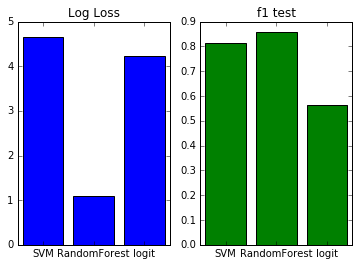

' So we see random forest is the best choice of the three. leading to low Log-Loss and high f1 test. Now i will try even more tuning'

In [225]:
## Comparing classifiers using a plot
plt.subplot(121)
plt.bar(range(len(logloss_results)), logloss_results.values(), align='center')
plt.xticks(range(len(logloss_results)), logloss_results.keys())
plt.title('Log Loss')

plt.subplot(122)
plt.bar(range(len(f1_results)), f1_results.values(), align='center',color='green')
plt.xticks(range(len(f1_results)), f1_results.keys())
plt.title('f1 test')
plt.show()

''' So we see random forest is the best choice of the three. leading to low Log-Loss and high f1 test. Now i will try even more tuning'''

# Grid Search

In [226]:
## Running all models with the GridSearch method which will iterate over the classifiers with different parameters,
## in order to find the best parameter fit for a best score.

clf = []
clf.append(LogisticRegression(multi_class='multinomial'))
clf.append(SVC(decision_function_shape='ovr',probability=True,random_state=42))
clf.append(RandomForestClassifier(random_state=42))
clf_names = ('logit','SVM','RandomForest')

grid_search_parm = []
grid_search_parm.append({'solver':['newton-cg', 'lbfgs'],'C':[0.001,0.01,0.1,1,100,1000,10000,100000]})
grid_search_parm.append({'kernel':['poly','rbf','sigmoid','linear'],'C':[0.001,0.01,0.1,1,100,1000,10000,100000]})
grid_search_parm.append({'n_estimators':[5,10,20,40,80]})

for i in range(3):
    classifier = GridSearchCV(clf[i],grid_search_parm[i],scoring='log_loss')   
    classifier.fit(X_train,y_train)
    print(clf_names[i] + " best log loss score = " + str(classifier.best_score_))

logit best log loss score = -0.310365545998
SVM best log loss score = -2.84574385414
RandomForest best log loss score = -1.08048688518


In [227]:
## We can see that the logit classifier outcomes with the best score (given the above parameters range).

Best parameters are {'solver': 'newton-cg', 'C': 100000}
Log loss = 0.204
f1 test = 94.95%


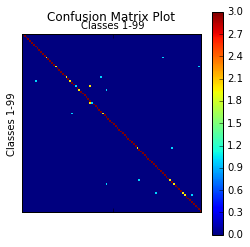

In [228]:
classifier = GridSearchCV(clf[0],grid_search_parm[0],scoring='log_loss')   
classifier.fit(X_train,y_train)
print("Best parameters are " + str(classifier.best_params_))

logloss = log_loss(y_test,classifier.predict_proba(X_test))
print("Log loss = {:.3f}".format(logloss))
test_prediction = classifier.predict(X_test)
f1 = f1_score(y_test,test_prediction, average='micro')
print('f1 test = {:.2%}'.format(f1))

confusion_mat_df = pd.DataFrame(confusion_matrix(y_test,test_prediction))
plt.matshow(confusion_mat_df)
plt.colorbar()
plt.title('Confusion Matrix Plot')
plt.xticks([50],['Classes 1-'+str(len(confusion_mat_df.columns))])
plt.yticks([])
plt.ylabel('Classes 1-'+str(len(confusion_mat_df.columns)))
plt.show()

# Preparing the submission set

In [229]:
## importing file into the DataFrame and extracting the feature matrix
test = pd.read_csv('test.csv',index_col=0)
X_sub = test.iloc[:,0:(64*3+1)]

print(X_sub.columns)             ## Checking we got the correct columns

Index(['margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6',
       'margin7', 'margin8', 'margin9', 'margin10',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=192)


In [230]:
## using the trained classifier on the new dataset 
#y_sub = classifier.predict(X_sub)
result_prob = classifier.predict_proba(X_sub)

In [231]:
## Create the DataFrame to hold the results, with proper row and column labeling
submission = pd.DataFrame(result_prob,test.axes[0],sorted(y.unique()))

In [232]:
## Exporting results to a .csv file
submission.to_csv("submission.csv")